In [14]:
pip install kmodes

In [15]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
path ='DATA/main.csv'
df = pd.read_csv(path,encoding='cp949')
df.head()

* 가격 기준으로 차종 나눔
   - 경형, 준중형, 소형SUV, 소형 => 소
   - 중형, 준중형SUV, 중형SUV, 수입 =>중
   - 승합, 준대형, 대형 => 대

In [19]:
car_dict = {'경형' : '소', 
            '준중형' : '소', 
            '준중형SUV' : '중', 
            '소형SUV' : '소',
            '소형' : '소',
            '준대형' : '대',
            '중형' : '중',
            '중형SUV' : '중',
            '승합': '대',
            '수입' : '중',
            '대형': '대'
            }

df['car_model']=df['car_model'].map(car_dict)

In [ ]:
  #datetime으로 자료형 변경
  df['reservation_start_at'] = pd.to_datetime(df['reservation_start_at'])
  df['reservation_return_at'] = pd.to_datetime(df['reservation_return_at'])

  #region2 이름 정제
  df.region2 = df.region2.str.replace('\u3000','_')

  # weather.csv와 지역이름 맞추기
  df['region'] = df.apply(lambda row : row['region2'].split('_')[0] if row['region1'] == '경기도' else row['region1'],axis =1)

  #use_total_hr 만들기
  df['use_time'] = df.reservation_return_at - df.reservation_start_at
  df['use_total_hr'] = df['use_time'].dt.total_seconds() / 3600
  df['use_total_hr'] = round( df['use_total_hr'], 2)

  df = df.drop(['reservation_return_at','reservation_start_at','use_time','region1','region2'],axis=1)
  df


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler =MinMaxScaler()
df['use_total_hr_mm'] = scaler.fit_transform(df[['use_total_hr']])
df

In [25]:
df.drop('use_total_hr', axis = 1,inplace =True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457067 entries, 0 to 457066
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   age_group        457067 non-null  int64  
 1   gender           457067 non-null  object 
 2   car_model        457067 non-null  object 
 3   region           457067 non-null  object 
 4   use_total_hr_mm  457067 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.4+ MB


In [26]:
# Inspect the categorical variables
df.select_dtypes('object').nunique()

gender        3
car_model     3
region       15
dtype: int64

In [28]:
# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['gender', 'car_model', 'region']
Categorical columns position  : [1, 2, 3]


In [ ]:
# Convert dataframe to matrix
dfMatrix = df.to_numpy()
dfMatrix

In [15]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 6):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


In [16]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
df_cost

,Cluster,Cost
0,1,79563777.371
1,2,37714901.980
2,3,20829273.436
3,4,14718957.338
4,5,11716662.296


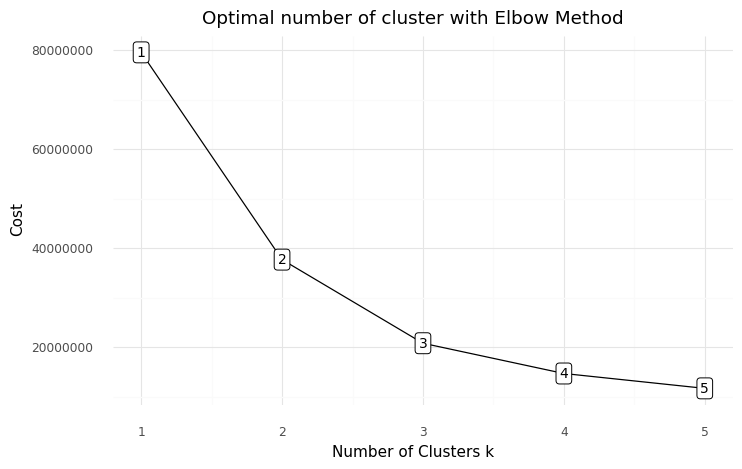

<ggplot: (8792238551929)>

In [17]:

# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [30]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([4, 4, 4, ..., 4, 1, 3], dtype=uint16)

In [ ]:
# Cluster centorid
kprototype.cluster_centroids_

In [32]:
# Check the iteration of the clusters created
kprototype.n_iter_

4

In [33]:
# Check the cost of the clusters created
kprototype.cost_

234554.38799104877

In [34]:
# Add the cluster to the dataframe
df['cluster_id'] = kprototype.labels_ 

In [ ]:
df

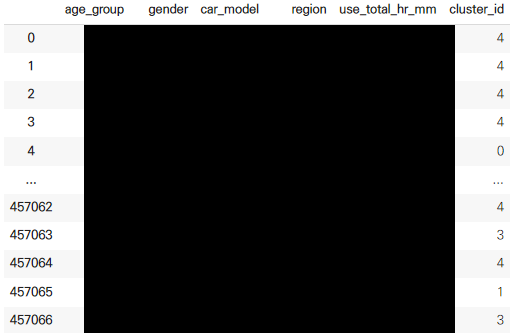

In [38]:
df['use_total_hr'] = scaler.inverse_transform(df[['use_total_hr_mm']])

In [20]:
df_0 = df[df['cluster_id'] ==0]
df_1 = df[df['cluster_id'] ==1]
df_2 = df[df['cluster_id'] ==2]
df_3 = df[df['cluster_id'] ==3]
df_4 = df[df['cluster_id'] ==4]